In [ ]:
import os
import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
import time
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
xt = np.memmap("drive/MyDrive/Ember_Data/trainx", dtype="float32", shape=(600000,2351))
yt = np.memmap("drive/MyDrive/Ember_Data/trainy", dtype="float32", shape=(600000,1))
x_test = np.memmap("drive/MyDrive/Ember_Data/x_test.txt", dtype="float32", shape=(200000, 2351))
y_test = np.memmap("drive/MyDrive/Ember_Data/y_test.txt", dtype="float32")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
batch_size = 64
device = torch.device('cuda')

x = torch.tensor(xt).to(device)
y = torch.tensor(yt).to(device)
y = y.type(torch.FloatTensor)

trainset = torch.utils.data.TensorDataset(x,y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
class Deep2Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2351,7000)
        self.bn = nn.BatchNorm1d(7000)
        self.dp = nn.Dropout(p=0.01)
        self.fc1 = nn.Linear(7000, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.dp1 = nn.Dropout(p=0.01)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.dp2 = nn.Dropout(p=0.01)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.dp3 = nn.Dropout(p=0.01)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dp4 = nn.Dropout(p=0.01)
        self.fc5 = nn.Linear(512,128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dp5 = nn.Dropout(p=0.01)
        self.fc6 = nn.Linear(128,1)

    def forward(self, x):
        x = F.relu(self.bn(self.fc(x)))
        x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dp3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dp4(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dp5(x)
        x = torch.sigmoid(self.fc6(x))
        return x

net = Deep2Net().to(device)

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2351,6000)
        self.bn = nn.BatchNorm1d(6000)
        self.dp = nn.Dropout(p=0.05)
        self.fc1 = nn.Linear(7000, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.dp1 = nn.Dropout(p=0.05)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.dp2 = nn.Dropout(p=0.01)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.dp3 = nn.Dropout(p=0.01)
        self.fc4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dp4 = nn.Dropout(p=0.01)
        self.fc5 = nn.Linear(512,128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dp5 = nn.Dropout(p=0.01)
        self.fc6 = nn.Linear(128,1)

    def forward(self, x):
        x = F.relu(self.bn(self.fc(x)))
        x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dp3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dp4(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dp5(x)
        x = torch.sigmoid(self.fc6(x))
        return x

net = DeepNet().to(device)

In [ ]:
class ShallowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2351,2048)
        self.bn = nn.BatchNorm1d(2048)
        self.dp = nn.Dropout(p=0.01)
        self.fc1 = nn.Linear(2048, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dp1 = nn.Dropout(p=0.01)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dp2 = nn.Dropout(p=0.01)
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dp3 = nn.Dropout(p=0.01)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.bn(self.fc(x)))
        x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dp3(x)
        x = torch.sigmoid(self.fc4(x))
        return x

net = ShallowNet().to(device)

In [ ]:
criterion = nn.BCELoss()
criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
running_losses = []
def train(epochs):
  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs).to(device)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              
              running_losses.append(running_loss / 2000);
              running_loss = 0.0

  print('Finished Training')

#train(2)

In [ ]:
start = time.time()
train(5)
end = time.time()
print("Training Time:",end-start)

[1,  2000] loss: 0.234
[1,  4000] loss: 0.230
[1,  6000] loss: 0.231
[1,  8000] loss: 0.233
[2,  2000] loss: 0.233
[2,  4000] loss: 0.232
[2,  6000] loss: 0.235
[2,  8000] loss: 0.232
[3,  2000] loss: 0.234
[3,  4000] loss: 0.233
[3,  6000] loss: 0.233
[3,  8000] loss: 0.232
[4,  2000] loss: 0.234
[4,  4000] loss: 0.231
[4,  6000] loss: 0.233
[4,  8000] loss: 0.233
[5,  2000] loss: 0.233
[5,  4000] loss: 0.236
[5,  6000] loss: 0.232
[5,  8000] loss: 0.230
Finished Training
Training Time: 445.47837376594543


In [ ]:
torch.save(net,"ember_deep2_model.pt")

In [ ]:
net = Deep2Net().to(device)
net = torch.load("ember_deep2_model.pt")

In [ ]:
batch_size = 64
device = torch.device('cuda')

xtest = torch.tensor(x_test).to(device)
ytest = torch.tensor(y_test).to(device)
ytest = ytest.type(torch.FloatTensor)
ytest = ytest.reshape(200000,1)

testset = torch.utils.data.TensorDataset(xtest,ytest)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
#test accuracy
correct = 0
total = 0
tp = 0
fp = 0
tn = 0
fn = 0
tot_neg = 0
tot_pos = 0
for i, data in enumerate(testloader, 0):
  with torch.no_grad():
    inputs, labels = data
    inputs = inputs.to(device)
    output = net(inputs)
    for j in range(output.shape[0]):
      pred = 0
      if output[j] >= .5:
        pred = 1
      if pred == labels[j]:
        if pred == 1:
          tp += 1
        else:
          tn += 1
        correct += 1
      else:
        if pred == 1:
          fp += 1
        else:
          fn +=1
      if labels[j]:
        tot_pos += 1
      else:
        tot_neg += 1
      total += 1

print("true positive rate:",tp/tot_pos)
print("false positive rate:",fp/tot_pos)
print("true negative rate:",tn/tot_neg)
print("false negative rate:",fn/tot_neg)
print("accuracy:",correct/total)   

true positive rate: 0.81007
false positive rate: 0.10274
true negative rate: 0.89726
false negative rate: 0.18993
accuracy: 0.853665


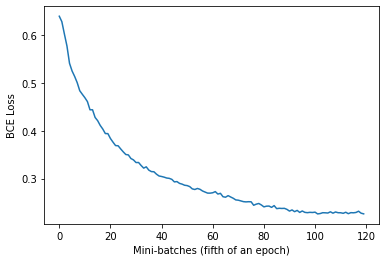

In [ ]:
plt.plot(running_losses)
plt.xlabel("Mini-batches (fifth of an epoch)")
plt.ylabel("BCE Loss")
plt.show()

In [ ]:
#train accuracy
correct = 0
total = 0
for i, data in enumerate(trainloader, 0):
  with torch.no_grad():
    inputs, labels = data
    inputs = inputs.to(device)
    output = net(inputs)
    for j in range(output.shape[0]):
      pred = 0
      if output[j] >= .5:
        pred = 1
      if pred == labels[j]:
        correct += 1
      total += 1


print(correct/total)   
#print(output)
#print(labels)